In [1]:
# Colab에 필요한 라이브러리를 설치합니다.
# 'accelerate'는 Trainer가 GPU/TPU를 쉽게 사용하도록 도와줍니다.
!pip install transformers datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
from datasets import load_dataset#, load_metric # Removed load_metric from datasets
from evaluate import load as load_metric # Imported load_metric from evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification, # ⭐️ 'AutoModel'이 아닌 'AutoModelForSequenceClassification'을 사용
    Trainer,
    TrainingArguments
)

# 1. 데이터셋 로드
datasets = load_dataset("dair-ai/emotion")
print(datasets)

# 2. 라벨 정보 확인 (총 6개)
label_names = datasets["train"].features["label"].names
num_labels = len(label_names)
print(f"라벨 수: {num_labels}, 라벨: {label_names}")

# 3. GPU/CPU 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용할 장치: {DEVICE}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
라벨 수: 6, 라벨: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
사용할 장치: cuda


In [3]:
# --- ⚠️ 중요 ⚠️ ---
# 지금은 테스트를 위해 'bert-base-uncased'를 사용합니다.
# 나중에 팀에서 만든 모델의 토크나이저 이름(또는 경로)으로 변경해야 합니다.
TOKENIZER_NAME = "bert-base-uncased"
# --------------------

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

# 3. 전처리 함수 정의
def preprocess_function(examples):
    # 'text'를 토크나이징합니다. (padding/truncation 동일)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# 4. 데이터셋 전체에 전처리 적용
tokenized_datasets = datasets.map(preprocess_function, batched=True)

# (참고) Trainer는 'set_format'을 따로 해주지 않아도 내부적으로 처리해 줍니다.
print("\n전처리 후 데이터 샘플 (input_ids):")
print(tokenized_datasets["train"][0]['input_ids'][:20]) # 앞 20개 토큰 ID만 출력

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


전처리 후 데이터 샘플 (input_ids):
[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [4]:
# --- ⚠️ 중요 ⚠️ ---
# 나중에 이 MODEL_NAME을 "팀의 BERT 모델 경로"로 교체하세요.
# (토크나이저와 동일한 이름을 사용)
MODEL_NAME = "bert-base-uncased"
# --------------------

# ⭐️ 핵심 ⭐️
# BERT 모델 위에 num_labels=6 짜리 분류 헤드를 "자동"으로 추가하여 로드합니다.
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels # 라벨 수 (6)
).to(DEVICE)

print("AutoModelForSequenceClassification 모델 로드 완료.")
print(model.classifier) # 모델의 마지막 분류 레이어 확인 (출력이 6이어야 함)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AutoModelForSequenceClassification 모델 로드 완료.
Linear(in_features=768, out_features=6, bias=True)


In [5]:
# 1. 사용할 평가 지표 로드 (여기서는 'accuracy')
metric = load_metric("accuracy")

# 2. 'Trainer'가 사용할 평가 함수 정의
def compute_metrics(eval_pred):
    """
    Trainer가 평가 시 호출하는 함수입니다.
    logits과 labels을 받아 accuracy를 계산합니다.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

print("평가 지표(accuracy) 계산 함수 준비 완료.")

평가 지표(accuracy) 계산 함수 준비 완료.


In [6]:
# Trainer에 전달할 모든 학습 설정을 정의합니다.
training_args = TrainingArguments(
    output_dir="./results",             # 모델과 로그가 저장될 폴더

    # --- 학습 관련 설정 ---
    num_train_epochs=3,                 # 총 학습 에포크
    per_device_train_batch_size=32,     # 학습 시 배치 크기
    learning_rate=5e-5,                 # (Learning Rate)

    # --- 평가 및 저장 설정 ---
    per_device_eval_batch_size=32,      # 평가 시 배치 크기
    eval_strategy="epoch",        # "epoch"마다 평가 실행
    save_strategy="epoch",              # "epoch"마다 모델 저장

    # --- 기타 설정 ---
    load_best_model_at_end=True,        # 학습 완료 후 최고 성능 모델을 로드
    metric_for_best_model="accuracy",   # 최고 성능의 기준 (accuracy)
    logging_steps=100,                  # 100 스텝마다 로그 출력
    report_to="none"                    # (Hugging Face Hub 연동 안 함)
)

print(f"'{training_args.output_dir}' 폴더에 결과가 저장됩니다.")

'./results' 폴더에 결과가 저장됩니다.


In [7]:
# 1. Trainer 객체 생성
# 학습에 필요한 모든 재료(모델, 설정, 데이터, 토크나이저, 평가함수)를 넣어줍니다.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 2. ⭐️ 학습 시작! ⭐️
# 이 한 줄이 Native PyTorch의 긴 '셀 6' 전체를 대체합니다.
print("--- Trainer로 학습 시작 ---")
trainer.train()
print("--- 학습 완료! ---")

--- Trainer로 학습 시작 ---


/tmp/ipython-input-1400766350.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.185900,0.188039,0.926000
2,0.116600,0.131499,0.939500
3,0.084600,0.132982,0.947000


--- 학습 완료! ---


In [8]:
from transformers import pipeline

print("--- 학습된 모델로 Softmax 확률 값 예측 ---")

# 1. 'text-classification' 파이프라인 생성
#    trainer.model은 'load_best_model_at_end=True'에 의해
#    가장 accuracy가 높았던 모델입니다.
classifier_pipeline = pipeline(
    "text-classification",
    model=trainer.model,     # ⭐️ 학습 완료된 베스트 모델
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1 # 0: GPU, -1: CPU
)

# 2. 테스트할 문장
test_text_1 = "I feel so happy and excited today!"
test_text_2 = "This is so frustrating and makes me angry."

# 3. 예측 실행 (return_all_scores=True로 모든 라벨 확률 받기)
results_1 = classifier_pipeline(test_text_1, return_all_scores=True)
results_2 = classifier_pipeline(test_text_2, return_all_scores=True)

# 4. 결과 출력
def print_results(text, results):
    print(f"\n입력 문장: \"{text}\"")
    print("--- 6개 라벨 Softmax 확률 값 ---")

    # 라벨 이름을 매칭시켜서 보기 좋게 출력
    for res in results[0]:
        label_name = label_names[int(res['label'].split('_')[-1])]
        print(f"{label_name:10}: {res['score']:.4f} ( {res['score']*100:6.2f} % )")

print_results(test_text_1, results_1)
print_results(test_text_2, results_2)

Device set to use cuda:0


--- 학습된 모델로 Softmax 확률 값 예측 ---

입력 문장: "I feel so happy and excited today!"
--- 6개 라벨 Softmax 확률 값 ---
sadness   : 0.0001 (   0.01 % )
joy       : 0.9994 (  99.94 % )
love      : 0.0001 (   0.01 % )
anger     : 0.0001 (   0.01 % )
fear      : 0.0001 (   0.01 % )
surprise  : 0.0002 (   0.02 % )

입력 문장: "This is so frustrating and makes me angry."
--- 6개 라벨 Softmax 확률 값 ---
sadness   : 0.0002 (   0.02 % )
joy       : 0.0001 (   0.01 % )
love      : 0.0001 (   0.01 % )
anger     : 0.9984 (  99.84 % )
fear      : 0.0010 (   0.10 % )
surprise  : 0.0002 (   0.02 % )


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## 🧪 Macro-F1 스크리닝
- **목표:** 빠른 하이퍼파라미터 탐색으로 유망한 조합 선별  
- **데이터:** train 2000, validation 500, test 500
- **학습 설정:** epoch=1, weight_decay=0.01, max_length=128  

- **조절 변수:**  
  | 변수 | 탐색 범위 | 설명 |
  |------|------------|------|
  | learning_rate | {5e-5, 3e-5, 2e-5, 1e-5} | 학습률 |
  | dropout | {0.0, 0.1, 0.2} | hidden·attention dropout |
  | warmup_ratio | {0.00, 0.06, 0.10} | 워밍업 비율 |
  | batch_size | {16, 32} | 배치 크기 |

- **사용된 조합 수:** 24  

- **평가 지표:** Macro-F1

- **결과 시각화:**  
  - 조합별 Macro-F1 막대그래프    

In [37]:
import numpy as np, os, torch
from transformers import AutoConfig, AutoModelForSequenceClassification, TrainingArguments, Trainer

BASE_MODEL = "bert-base-uncased"
OUTPUT_DIR = "./results_step1"

# 사용할 model variation : (learning rate, dropout, warmup_ratio, batch_size)
HYPER_CANDIDATES_STEP1 = [
    (5e-5, 0.0, 0.00, 16),
    (5e-5, 0.0, 0.06, 32),
    (5e-5, 0.1, 0.10, 16),
    (5e-5, 0.1, 0.00, 32),
    (5e-5, 0.2, 0.06, 16),
    (5e-5, 0.2, 0.10, 32),

    (3e-5, 0.0, 0.10, 16),
    (3e-5, 0.0, 0.00, 32),
    (3e-5, 0.1, 0.06, 16),
    (3e-5, 0.1, 0.10, 32),
    (3e-5, 0.2, 0.00, 16),
    (3e-5, 0.2, 0.06, 32),

    (2e-5, 0.0, 0.06, 16),
    (2e-5, 0.0, 0.10, 32),
    (2e-5, 0.1, 0.00, 16),
    (2e-5, 0.1, 0.06, 32),
    (2e-5, 0.2, 0.10, 16),
    (2e-5, 0.2, 0.00, 32),

    (1e-5, 0.0, 0.10, 16),
    (1e-5, 0.0, 0.00, 32),
    (1e-5, 0.1, 0.06, 16),
    (1e-5, 0.1, 0.10, 32),
    (1e-5, 0.2, 0.00, 16),
    (1e-5, 0.2, 0.06, 32),
]

In [38]:
# 로드 직후 서브셋 스위치와 크기
SEED = 42
N_TRAIN, N_VAL, N_TEST = 2000, 500, 500

# 서브셋 생성
from datasets import DatasetDict
datasets_s1 = DatasetDict({
    "train":      datasets["train"].shuffle(seed=SEED).select(range(min(N_TRAIN, len(datasets["train"])))),
    "validation": datasets["validation"].shuffle(seed=SEED).select(range(min(N_VAL,   len(datasets["validation"])))),
    "test":       datasets["test"].shuffle(seed=SEED).select(range(min(N_TEST,  len(datasets["test"])))),
})

tokenized_datasets = datasets_s1.map(preprocess_function, batched=True)

In [39]:
from transformers import set_seed

# 평가 지표 : Macro-F1 Metric Definition
def compute_metrics_step1(eval_pred):
    metric_step1 = load_metric("f1")
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric_step1.compute(predictions=preds, references=labels, average="macro")

# 모델을 자동으로 만들어 평가 결과 반환
def level1_train(hyper_tuple):
  set_seed(SEED)
  lr, dr, wp, bs = hyper_tuple

  cfg = AutoConfig.from_pretrained(
    BASE_MODEL,
    num_labels=6,
    hidden_dropout_prob=dr,
    attention_probs_dropout_prob=dr
  )
  local_model = AutoModelForSequenceClassification.from_pretrained(
      BASE_MODEL, config=cfg
  ).to(DEVICE)

  odir = os.path.join(OUTPUT_DIR, f"lr{lr}_dr{dr}_wp{wp}_bs{bs}")

  training_args = TrainingArguments(
    output_dir=odir,
    num_train_epochs=1,
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs,
    learning_rate=lr,
    warmup_ratio=wp,
    eval_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",
    seed=SEED,
    fp16=True if getattr(DEVICE, "type", "cpu") == "cuda" else False
  )

  # Trainer 구성
  trainer = Trainer(
    model=local_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_step1,
  )

  # 학습 및 평가
  trainer.train()
  result = trainer.evaluate()

  # eval_f1 반환
  return result.get("eval_f1", 0.0)

In [40]:
results_list = []

for i, hyper in enumerate(HYPER_CANDIDATES_STEP1):
    print(f"\n[{i+1}/{len(HYPER_CANDIDATES_STEP1)}] 조합 실행 중: {hyper}")

    try:
        f1_score = level1_train(hyper)
        results_list.append({
            "index": i + 1,
            "params": hyper,
            "eval_f1": f1_score
        })

    except Exception as e:
        print(f"→ 오류 발생: {e}")
        results_list.append({
            "index": i + 1,
            "params": hyper,
            "eval_f1": None,
            "error": str(e)
        })

print("\n=== 전체 완료 ===")
print(f"총 {len(results_list)}개 결과 수집됨.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[1/24] 조합 실행 중: (5e-05, 0.0, 0.0, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.862900,0.705090,0.593500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[2/24] 조합 실행 중: (5e-05, 0.0, 0.06, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.331700,1.024735,0.351939


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[3/24] 조합 실행 중: (5e-05, 0.1, 0.1, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.100200,0.944218,0.466617


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[4/24] 조합 실행 중: (5e-05, 0.1, 0.0, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.397500,1.145740,0.235671



[5/24] 조합 실행 중: (5e-05, 0.2, 0.06, 16)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.216900,1.104336,0.319904



[6/24] 조합 실행 중: (5e-05, 0.2, 0.1, 32)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.522600,1.271607,0.223374


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[7/24] 조합 실행 중: (3e-05, 0.0, 0.1, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.099300,0.997129,0.448059


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[8/24] 조합 실행 중: (3e-05, 0.0, 0.0, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.438800,1.222286,0.221768


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[9/24] 조합 실행 중: (3e-05, 0.1, 0.06, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.224400,1.171190,0.258724


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[10/24] 조합 실행 중: (3e-05, 0.1, 0.1, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.541600,1.382159,0.216725


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[11/24] 조합 실행 중: (3e-05, 0.2, 0.0, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.352400,1.246424,0.222927


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[12/24] 조합 실행 중: (3e-05, 0.2, 0.06, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.588000,1.513772,0.191307



[13/24] 조합 실행 중: (2e-05, 0.0, 0.06, 16)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.251100,1.187810,0.256854


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[14/24] 조합 실행 중: (2e-05, 0.0, 0.1, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.547400,1.442007,0.213813


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[15/24] 조합 실행 중: (2e-05, 0.1, 0.0, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.439500,1.346738,0.218012


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[16/24] 조합 실행 중: (2e-05, 0.1, 0.06, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.573000,1.530556,0.188224


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[17/24] 조합 실행 중: (2e-05, 0.2, 0.1, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.508800,1.445106,0.210328


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[18/24] 조합 실행 중: (2e-05, 0.2, 0.0, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.587000,1.542849,0.174716


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[19/24] 조합 실행 중: (1e-05, 0.0, 0.1, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.503500,1.501354,0.200429


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[20/24] 조합 실행 중: (1e-05, 0.0, 0.0, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.579800,1.560511,0.182418


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[21/24] 조합 실행 중: (1e-05, 0.1, 0.06, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.540600,1.543278,0.191063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[22/24] 조합 실행 중: (1e-05, 0.1, 0.1, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.602100,1.569626,0.168098



[23/24] 조합 실행 중: (1e-05, 0.2, 0.0, 16)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.569000,1.563059,0.177083


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[24/24] 조합 실행 중: (1e-05, 0.2, 0.06, 32)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,1.627300,1.578701,0.159277



=== 전체 완료 ===
총 24개 결과 수집됨.


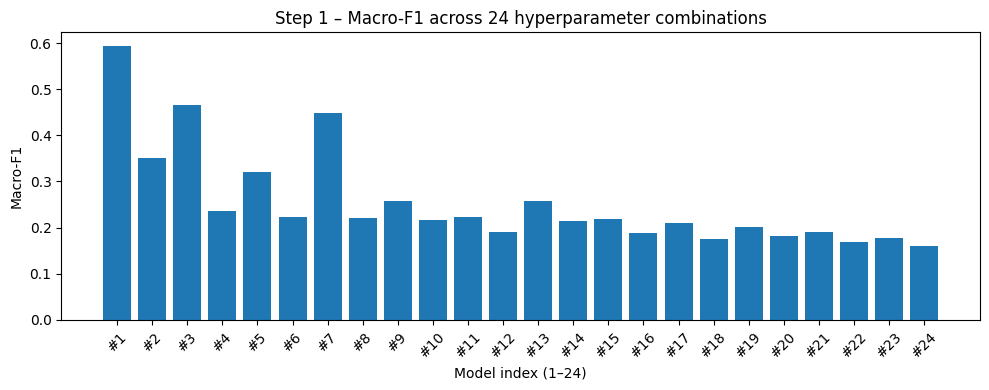

In [41]:
import matplotlib.pyplot as plt

f1_scores = [r["eval_f1"] for r in results_list]  # 24개 결과
labels = [f"#{i+1}" for i in range(len(f1_scores))]

plt.figure(figsize=(10,4))
plt.bar(labels, f1_scores)
plt.ylabel("Macro-F1")
plt.xlabel("Model index (1–24)")
plt.title("Step 1 – Macro-F1 across 24 hyperparameter combinations")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# ✅ 평가용 데이터 비율 조정 후 다중 조합 테스트
from datasets import DatasetDict

SEED = 42
train_ratio = 0.3
train_size = int(len(datasets["train"]) * train_ratio)

datasets_eval = DatasetDict({
    "train":      datasets["train"].shuffle(seed=SEED).select(range(train_size)),
    "validation": datasets["validation"]
})

tokenized_eval = datasets_eval.map(preprocess_function, batched=True)
tokenized_datasets = tokenized_eval  # level1_train에서 참조하므로 갱신

# ✅ 비교할 조합 3개 (#1, #3, #7)
candidates = [
    (5e-5, 0.0, 0.00, 16),  # #1
    (5e-5, 0.1, 0.10, 16),  # #3
    (3e-5, 0.0, 0.10, 16),  # #7
    (5e-5, 0.0, 0.10, 16),  # result
]

results = []
for tup in candidates:
    print(f"\n조합 실행 중: {tup}")
    score = level1_train(tup)
    results.append((tup, score))
    print(f"검증 Macro-F1 = {score:.4f}")

# ✅ 결과 요약
print("\n=== 요약 ===")
for tup, score in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{tup} → F1: {score:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



조합 실행 중: (5e-05, 0.0, 0.0, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.286000,0.284010,0.876095


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


검증 Macro-F1 = 0.8761

조합 실행 중: (5e-05, 0.1, 0.1, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.348900,0.343643,0.861649


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


검증 Macro-F1 = 0.8616

조합 실행 중: (3e-05, 0.0, 0.1, 16)


/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.377100,0.393378,0.835296


검증 Macro-F1 = 0.8353

조합 실행 중: (5e-05, 0.0, 0.1, 16)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-397033612.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.323800,0.297232,0.881246


검증 Macro-F1 = 0.8812

=== 요약 ===
(5e-05, 0.0, 0.1, 16) → F1: 0.8812
(5e-05, 0.0, 0.0, 16) → F1: 0.8761
(5e-05, 0.1, 0.1, 16) → F1: 0.8616
(3e-05, 0.0, 0.1, 16) → F1: 0.8353


## 🧪 두 모델 에포크 비교
- 목표: 동일 데이터에서 baseline vs candidate의 에포크별 일반화 성능 비교 및 최적 epoch 확정  
- 데이터: train 전체 16,000 + validation 2,000 (test는 최종 1회만 사용)  
- 학습 설정: weight_decay=0.01, max_length=128, early stopping 허용(patience=1)

- 비교 대상:
  - baseline: (learning_rate=5e-5, warmup_ratio=0.00, batch_size=32, dropout=0.0)
  - candidate: (learning_rate=5e-5, warmup_ratio=0.10, batch_size=16, dropout=0.0)  ← 1단계 상위 (#1, #3, #7 중 채택)

- 조절 변수:  
  | 변수 | 탐색 범위 | 설명 |
  |------|------------|------|
  | epoch | {3, 4, 5} | 에포크별 성능 곡선 비교 |
  | label_smoothing | {0.0, 0.05} | 클래스 혼동 완화(선택) |

- 평가 지표:
  - Macro-F1(검증, 에포크별)
  - Per-class F1(최종 에포크)
  - Latency(ms/샘플, 최종 모델)
  - Top-2 Accuracy(선택, 최종 모델)

- 결과 시각화:
  - 단일 그래프: Epoch–Macro-F1(두 모델 라인 함께 표시)
  - 선택: Confusion Matrix(최종 모델), Per-class F1 막대

- 결과 활용:
  1) 각 모델의 Val Macro-F1 최대 에포크 선택  
  2) 두 모델의 최고 Macro-F1 비교. 동률이면 Latency 낮은 모델 선택  
  3) 혼동 클래스가 뚜렷하면(label_smoothing=0.05) 재평가 후 최종 확정

In [83]:
# 전체 데이터 사용
tokenized_datasets = datasets.map(preprocess_function, batched=True)
len(tokenized_datasets["train"]), len(tokenized_datasets["validation"]), len(tokenized_datasets["test"])

(16000, 2000, 2000)

In [84]:
from transformers import TrainerCallback

# F1 기준 overfit 감지 콜백
class OverfitStopper(TrainerCallback):
    def __init__(self, patience=2):
        self.patience = patience
        self.best_f1 = -float("inf")
        self.bad_epochs = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        cur_f1 = metrics.get("eval_f1")
        if cur_f1 is None:
            return
        # F1 향상 없음 → bad epoch 누적
        if cur_f1 <= self.best_f1:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                print(f"\n[조기 중단] F1이 {self.patience}회 연속 하락 → epoch {int(state.epoch)}에서 종료")
                control.should_training_stop = True
        else:
            self.best_f1 = cur_f1
            self.bad_epochs = 0

In [85]:
# 평가 기록용 콜백
class EvalHistory(TrainerCallback):
    def __init__(self):
        self.epochs, self.f1s, self.losses = [], [], []
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.epochs.append(int(state.epoch))
        self.f1s.append(metrics.get("eval_f1", np.nan))
        self.losses.append(metrics.get("eval_loss", np.nan))

In [86]:
# 실험 실행 함수
def run_exp(name, lr, dr, wp, bs, epochs):
    set_seed(SEED)
    cfg = AutoConfig.from_pretrained(
        BASE_MODEL,
        num_labels=6,
        hidden_dropout_prob=dr,
        attention_probs_dropout_prob=dr
    )
    model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, config=cfg).to(DEVICE)

    args = TrainingArguments(
        output_dir=f"./results_cmp/{name}",
        num_train_epochs=epochs,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        learning_rate=lr,
        warmup_ratio=wp,
        eval_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        weight_decay=0.01,
        logging_steps=100,
        report_to="none",
        seed=42,
        fp16=(DEVICE.type == "cuda"),
    )

    history = EvalHistory()
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_step1,
        callbacks=[history],
    )

    trainer.train()
    del trainer, model
    if DEVICE.type == "cuda": torch.cuda.empty_cache()

    return {"name": name, "epoch": history.epochs, "f1": history.f1s}

In [87]:
# baseline vs candidate 학습 곡선 비교

set_seed(SEED)
os.makedirs("./results_cmp", exist_ok=True)

# baseline vs candidate
exps = [
    ("baseline(bs32,lr5e-5,wp0.0)", 5e-5, 0.0, 0.0, 32),
    ("candidate(bs16,lr5e-5,wp0.1)", 5e-5, 0.0, 0.1, 16)
]
histories = [run_exp(n, lr, dr, wp, bs, 12) for n, lr, dr, wp, bs in exps]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-90761627.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.175100,0.145234,0.904640
2,0.137100,0.199736,0.898161
3,0.093400,0.144147,0.909172
4,0.079000,0.223348,0.908510
5,0.045100,0.239501,0.909458
6,0.018900,0.280105,0.912648
7,0.017100,0.304566,0.907547
8,0.007000,0.353313,0.905130
9,0.003900,0.349983,0.906619
10,0.003900,0.367439,0.911242


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-90761627.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.231700,0.253106,0.887216
2,0.135400,0.252153,0.891863
3,0.129400,0.176076,0.914276
4,0.120600,0.209645,0.914553
5,0.065300,0.293277,0.907929
6,0.054700,0.306237,0.911356
7,0.027100,0.332606,0.915713
8,0.017700,0.377956,0.913644
9,0.007200,0.423942,0.910599
10,0.007700,0.427242,0.913182



[Epoch-wise Validation Macro-F1]
epoch 1: baseline(bs32,lr5e-5,wp0.0)=0.9046 | candidate(bs16,lr5e-5,wp0.1)=0.8872
epoch 2: baseline(bs32,lr5e-5,wp0.0)=0.8982 | candidate(bs16,lr5e-5,wp0.1)=0.8919
epoch 3: baseline(bs32,lr5e-5,wp0.0)=0.9092 | candidate(bs16,lr5e-5,wp0.1)=0.9143
epoch 4: baseline(bs32,lr5e-5,wp0.0)=0.9085 | candidate(bs16,lr5e-5,wp0.1)=0.9146
epoch 5: baseline(bs32,lr5e-5,wp0.0)=0.9095 | candidate(bs16,lr5e-5,wp0.1)=0.9079
epoch 6: baseline(bs32,lr5e-5,wp0.0)=0.9126 | candidate(bs16,lr5e-5,wp0.1)=0.9114
epoch 7: baseline(bs32,lr5e-5,wp0.0)=0.9075 | candidate(bs16,lr5e-5,wp0.1)=0.9157
epoch 8: baseline(bs32,lr5e-5,wp0.0)=0.9051 | candidate(bs16,lr5e-5,wp0.1)=0.9136
epoch 9: baseline(bs32,lr5e-5,wp0.0)=0.9066 | candidate(bs16,lr5e-5,wp0.1)=0.9106
epoch 10: baseline(bs32,lr5e-5,wp0.0)=0.9112 | candidate(bs16,lr5e-5,wp0.1)=0.9132
epoch 11: baseline(bs32,lr5e-5,wp0.0)=0.9080 | candidate(bs16,lr5e-5,wp0.1)=0.9197
epoch 12: baseline(bs32,lr5e-5,wp0.0)=0.9101 | candidate(bs16,

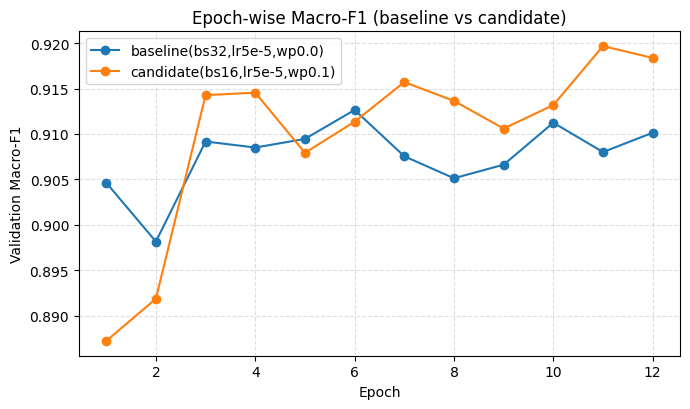

In [88]:
# === 승자 및 최고 성능 지점 계산 ===
per_model_best = []
for h in histories:
    e, f = max(zip(h["epoch"], h["f1"]), key=lambda t: t[1])
    per_model_best.append({"name": h["name"], "epoch": e, "f1": f})

winner = max(per_model_best, key=lambda d: d["f1"])

print("\n[Best per model]")
for bm in per_model_best:
    print(f"{bm['name']} → best@epoch {bm['epoch']}: F1={bm['f1']:.4f}")

print(f"\n[Winner] {winner['name']} @ epoch {winner['epoch']}  F1={winner['f1']:.4f}")

# === 그래프에 최고점 마커 표시 ===
for bm in per_model_best:
    plt.scatter(bm["epoch"], bm["f1"], s=90, marker="o", edgecolors="black", zorder=5)
    plt.text(bm["epoch"] + 0.05, bm["f1"], f"e{bm['epoch']}:{bm['f1']:.3f}", fontsize=8)

# 승자에 별표
plt.scatter(winner["epoch"], winner["f1"], s=140, marker="*", zorder=6)